<H1> Searchlight Analysis </H1>
Note: Have to do in condo with virtual env
`conda install -c conda-forge openblas=0.2.19`

In [16]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
sys.path.append('../Multivariate_analyses_Daphne/')
    
# Import libraries
import nibabel as nib
import numpy as np
import os 
import time
from nilearn import datasets, surface, plotting
from brainiak.searchlight.searchlight import Searchlight
from brainiak.fcma.preprocessing import prepare_searchlight_mvpa_data
from brainiak import io
from pathlib import Path
from shutil import copyfile
import scipy.stats

# Import machine learning libraries
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.svm import SVC


import matplotlib.pyplot as plt
import seaborn as sns 

# Import own project library
import utils

# Set printing precision
np.set_printoptions(precision=2, suppress=True)

%matplotlib inline
%matplotlib notebook
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

Autosaving every 5 seconds



## 1. Executing the searchlight workflow<a id="exe_wf"></a>
### Set searchlight parameters <a id="set_param"></a>

To run the [searchlight](http://brainiak.org/docs/brainiak.searchlight.html) function in BrainIAK you need the following parameters:  

1. **data** = The brain data as a 4D volume.  
2. **mask** = A binary mask specifying the "center" voxels in the brain around which you want to perform searchlight analyses. A searchlight will be drawn around every voxel with the value of 1. Hence, if you chose to use the wholebrain mask as the mask for the searchlight procedure, the searchlight may include voxels outside of your mask when the "center" voxel is at the border of the mask. It is up to you to decide whether then to include these results.  
3. **bcvar** = An additional variable which can be a list, numpy array, dictionary, etc. you want to use in your searchlight kernel. For instance you might want the condition labels so that you can determine to which condition each 3D volume corresponds. If you don't need to broadcast anything, e.g, when doing RSA, set this to 'None'.  
4. **sl_rad** = The size of the searchlight's radius, excluding the center voxel. This means the total volume size of the searchlight, if using a cube, is defined as: ((2 * sl_rad) + 1) ^ 3.  
5. **max_blk_edge** = When the searchlight function carves the data up into chunks, it doesn't distribute only a single searchlight's worth of data. Instead, it creates a block of data, with the edge length specified by this variable, which determines the number of searchlights to run within a job.  
6. **pool_size** = Maximum number of cores running on a block (typically 1).  

In [5]:
# BOLD signals for all subjects, all games (games, voxels, subjects)
path = './data/'
all_bold_vol = np.load(path+'bold_data_games.npy')

# load mask and get voxel coordinates
mask_arr = np.load(path+'mask_arr.npy') # all masks are the same
mask_mat = mask_arr[0] # so we can pick any one from the array
coords_mat = np.array(np.where(mask_mat == 1)) # so need one set of voxel coordinates for all
coords_mat[[0, 2]] = coords_mat[[2, 0]] # exchange the rows
print(coords_mat.shape) #coords_mat contains voxel coordinates of brain region voxels

# mask_nii is the functional mask, this selects the brain voxels
mask_nii = nib.load(os.path.join(path, 'mask.nii')) 
print(mask_nii.shape)
# we get the brain mask (boolean array) with the .dataobj method
# brain_mask contains all voxels, 1 at brain regions
# coords_mat can be used to index into brain_mask 
brain_mask = np.array(mask_nii.dataobj)
print(brain_mask.shape)
affine_mat = mask_nii.affine
dimsize = mask_nii.header.get_zooms()

# Get the list of nonzero voxel coordinates from the nii mask. SAME AS coords_mat
coords_nii = np.where(brain_mask)
print(coords_nii[0])
print(coords_mat[0])
# cords_nii corresponds to the bold_vol <=> verify with Daphne

# this where we plot our mask ON (sometimes called brain_nii) - the anatomical/structural image
mean_nii = nib.load(os.path.join(path, 'mean.nii')) 

(3, 220075)
(79, 95, 79)
(79, 95, 79)
[ 2  3  3 ... 74 74 74]
[39 40 36 ... 34 35 44]


In [6]:
# Behavioral RDM
behavior_RDM = np.load(path+'behavior_RDM.npy')

In [5]:
# Set up 4D BOLD for each subject
small_mask = np.zeros(brain_mask.shape)
small_mask[42, 28, 26] = 1
coords = tuple(coords_nii)
vol4D = mask_nii.shape+(6,)

# For 8 subjects
all_bold = []
for sub_id in range(8):
    isc_vol = np.zeros(vol4D)
    bold_vol = all_bold_vol[:,:,sub_id]
    for i in range(6):
        for j in range(len(coords[0])):
            isc_vol[(coords[0][j], coords[1][j], coords[2][j], i)] = bold_vol[i][j]
    all_bold.append(isc_vol)

# Preset the variables
data = all_bold
mask = small_mask
bcvar = behavior_RDM
sl_rad = 1
max_blk_edge = 5
pool_size = 1

# Start the clock to time searchlight
begin_time = time.time()

# Create the searchlight object
sl = Searchlight(sl_rad=sl_rad,max_blk_edge=max_blk_edge)
print("Setup searchlight inputs")
print("Number of subjects: " + str(len(data)))
print("Input data shape: " + str(data[0].shape))
print("Input mask shape: " + str(mask.shape) + "\n")

# Distribute the information to the searchlights (preparing it to run)
sl.distribute(data, mask)
# Data that is needed for all searchlights is sent to all cores via the sl.broadcast function. 
#In this example, we are sending the labels for classification to all searchlights.
sl.broadcast(bcvar)

Setup searchlight inputs
Number of subjects: 8
Input data shape: (79, 95, 79, 6)
Input mask shape: (79, 95, 79)



In [8]:
# Set up the kernel, RDM analysis
def rdm_all(data, sl_mask, myrad, bcvar):
    t1 = time.time()
    all_rho = []
    behavior_RDM = bcvar
    # Loop over subject: 
    for idx in range(len(data)):
        data4D = data[idx]
        bolddata_sl = data4D.reshape(sl_mask.shape[0] * sl_mask.shape[1] * sl_mask.shape[2], data[0].shape[3]).T

        neural_RDM = 1-np.corrcoef(bolddata_sl)
        subject_spearman = scipy.stats.spearmanr(neural_RDM, behavior_RDM,axis=None)
        all_rho.append(subject_spearman.correlation)
        
    tstats,p = scipy.stats.ttest_1samp(np.arctanh(all_rho), popmean=0)
    print('one voxel takes time:', time.time() - t1, "s")
    print(tstats, p)
    return (tstats, p)

# Execute searchlight on 8 subjects
print("Begin Searchlight\n")
sl_result_allsubj = sl.run_searchlight(rdm_all, pool_size=pool_size)
print("End Searchlight\n")
print(sl_result_allsubj[mask==1])

Begin Searchlight

one voxel takes time: 0.01547384262084961 s
6.558373922306658 0.0003163431733864217
End Searchlight

[(6.558373922306658, 0.0003163431733864217)]


## TODO Change to partial correlation
1. Documentation https://pingouin-stats.org/generated/pingouin.partial_corr.html
2. Get RDM for each of the four metrics
3. Get partial corr (spearman) between rule RDM and neural RDM, while controling for the other three RDM matrices

## 2. Paint tstats onto brain image

#### Save to matlab

In [24]:
# import scipy.io
# scipy.io.savemat(result_prefix+'tstats.mat', mdict={'tstats': tstats})
# scipy.io.savemat(result_prefix+'pvalues.mat', mdict={'p': pvalues})

radius 5
Display t statistics with a corresponding p < 0.05


<IPython.core.display.Javascript object>


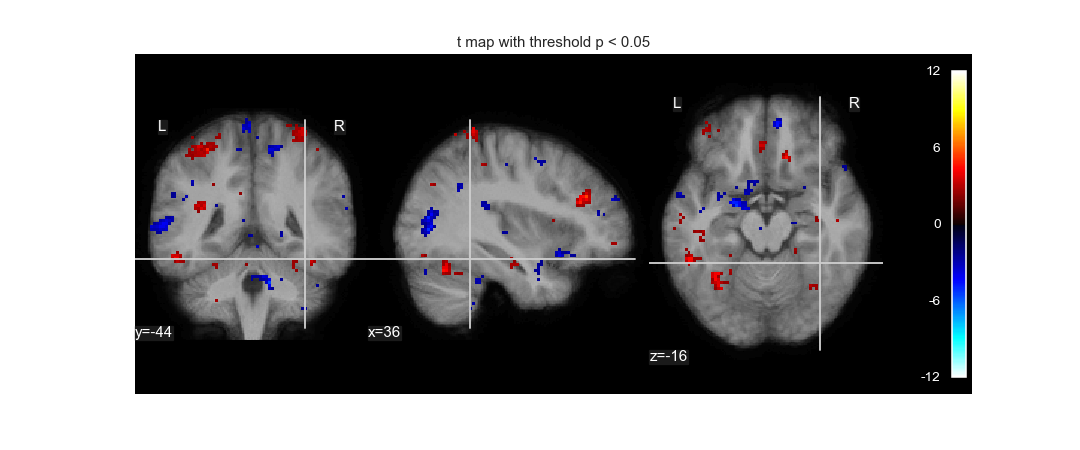

radius 6
Display t statistics with a corresponding p < 0.05


<IPython.core.display.Javascript object>


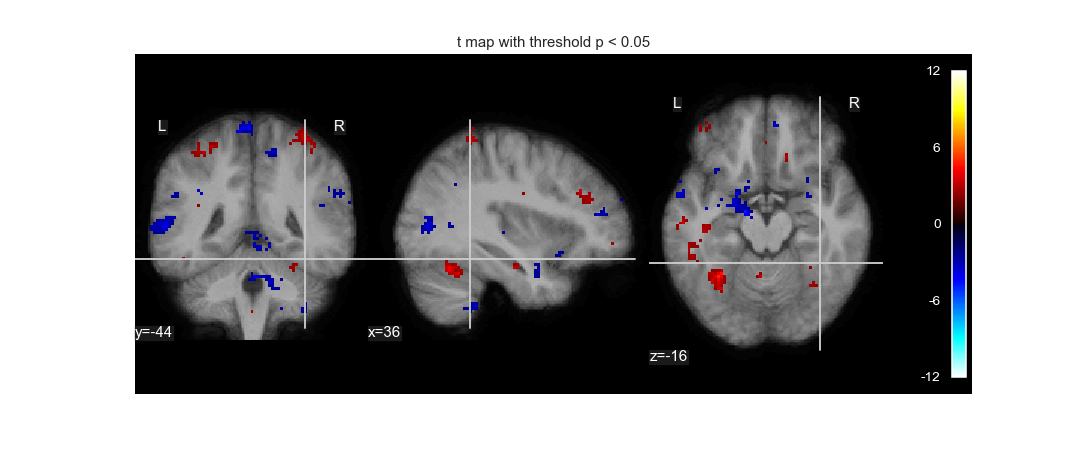

radius 7
Display t statistics with a corresponding p < 0.05


<IPython.core.display.Javascript object>


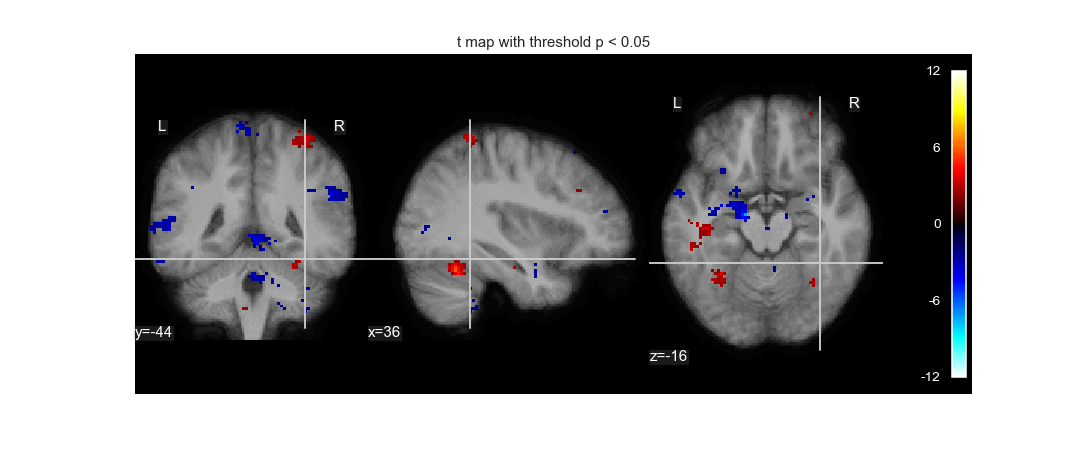

radius 8
Display t statistics with a corresponding p < 0.05


<IPython.core.display.Javascript object>


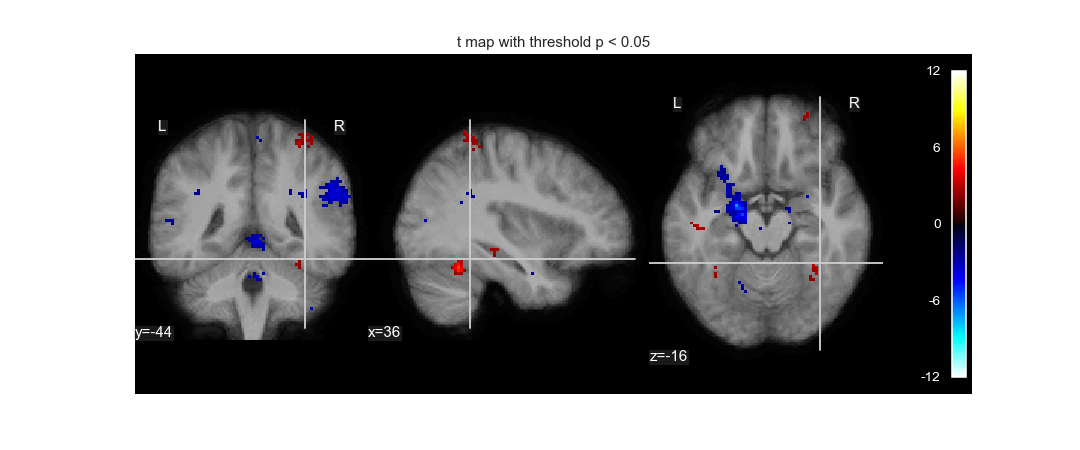

In [33]:
path = './data/'
for r in [5,6,7,8]:
    radius = r
    result_prefix = path+'r'+str(radius)+'_'
    tstats = np.load(result_prefix +'tstats_all.npy')
    pvalues = np.load(result_prefix+'pvalues_all.npy')

    p_thre = 0.05
    print("radius "+str(radius))
    nifti_games = utils.plot_statistical_map(coords=coords_mat, 
                               tstats=tstats, 
                               pvalues=pvalues, 
                               brain_nii=mean_nii, 
                               mask_nii=mask_nii, 
                               threshold=True,
                               theta=p_thre,
                               cut_coords=[36, -44, -16],
                               vmax=12)
    view = plotting.view_img(nifti_games, threshold=p_thre)
    view

### Surface plots

In [19]:
fsaverage = datasets.fetch_surf_fsaverage5()
# Make a "texture" with isc_nifti (NOTE: need to make a different for left and right!)
texture_left = surface.vol_to_surf(nifti_games, fsaverage.pial_left) 
texture_right = surface.vol_to_surf(nifti_games, fsaverage.pial_right) 

<IPython.core.display.Javascript object>


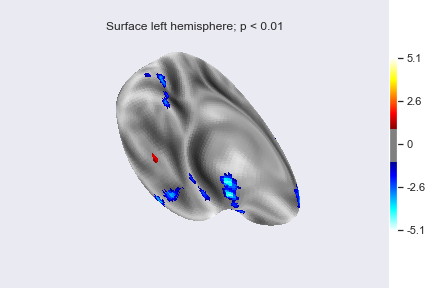

<IPython.core.display.Javascript object>


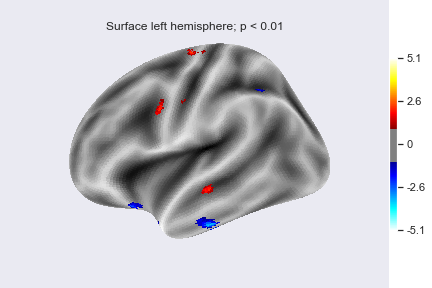

<IPython.core.display.Javascript object>


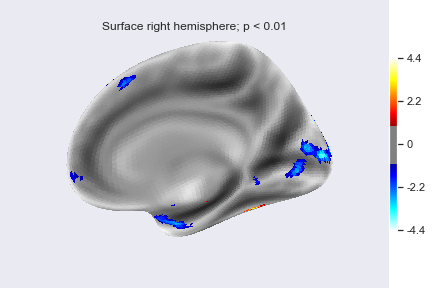

<IPython.core.display.Javascript object>


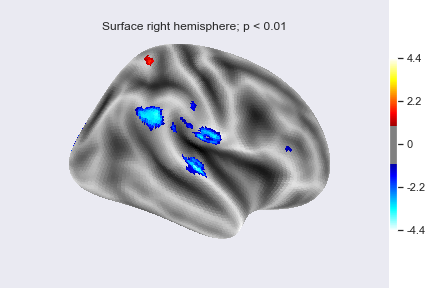

In [20]:
surf_map_left_medial = plotting.plot_surf_stat_map(
                                fsaverage.infl_left, 
                                texture_left, 
                                hemi='left', 
                                view='medial',
                                title='Surface left hemisphere; p < 0.01',
                                threshold=1., 
                                colorbar=True,
                                bg_map=fsaverage.sulc_left)

surf_map_left_lateral = plotting.plot_surf_stat_map(
                                fsaverage.infl_left, 
                                texture_left, 
                                hemi='left', 
                                view='lateral', 
                                title='Surface left hemisphere; p < 0.01',
                                threshold=1., 
                                colorbar=True,
                                bg_map=fsaverage.sulc_left)

surf_map_right_medial = plotting.plot_surf_stat_map(
                                fsaverage.infl_right, 
                                texture_right, 
                                hemi='right', 
                                view='medial', 
                                title='Surface right hemisphere; p < 0.01',
                                threshold=1., 
                                colorbar=True,
                                bg_map=fsaverage.sulc_right)

surf_map_right_lateral = plotting.plot_surf_stat_map(
                                fsaverage.infl_right, 
                                texture_right, 
                                hemi='right', 
                                view='lateral', 
                                title='Surface right hemisphere; p < 0.01',
                                threshold=1., 
                                colorbar=True,
                                bg_map=fsaverage.sulc_right)